In [3]:
# Training and Comparison: Global vs Conditional
# Compare the two approaches to generate MNIST digits

import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
import time
import sys
import os
from pathlib import Path

# Project root = parent of the notebooks folder
BASE_DIR = Path.cwd().parent
SRC_DIR = BASE_DIR / "src"

sys.path.insert(0, str(SRC_DIR))

from generator import GlobalGenerator, ConditionalGenerator

plt.style.use('seaborn-v0_8-darkgrid')
np.random.seed(42)

print("="*70)
print("COMPARISON: GLOBAL vs CONDITIONAL")
print("="*70)

COMPARAISON : GLOBAL vs CONDITIONNEL


In [4]:
# =============================================================================
# 1. DATA LOADING
# =============================================================================
print("\n[1/5] Loading MNIST...")
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train_flat = x_train.reshape(-1, 784) / 255.0
x_test_flat = x_test.reshape(-1, 784) / 255.0
print(f"✓ {len(x_train)} training images")




[1/5] Chargement de MNIST...
✓ 60000 images d'entraînement


In [5]:
# =============================================================================
# 2. GLOBAL TRAINING with bandwidth optimization
# =============================================================================
print("\n[2/5] Training the GLOBAL generator...")
print("-"*70)

start_time = time.time()

# Create a temporary generator to optimize bandwidth
print("\n🔍 Bandwidth optimization via cross-validation...")
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KernelDensity

# Prepare data for optimization
x_sample = x_train_flat[:5000]  # Subset for speed
from sklearn.decomposition import PCA
pca_temp = PCA(n_components=50, random_state=42)
x_sample_pca = pca_temp.fit_transform(x_sample)

# Grid search over different bandwidths
bandwidths = np.linspace(0.5, 2.5, 10)
grid = GridSearchCV(
    KernelDensity(kernel='gaussian'),
    {'bandwidth': bandwidths},
    cv=5,  # 5-fold cross-validation
    n_jobs=-1  # Use all CPUs
)

print(f"  Tested bandwidths: {bandwidths[0]:.2f} - {bandwidths[-1]:.2f}")
print(f"  Cross-validation: 5-fold")
grid.fit(x_sample_pca)

best_bandwidth = grid.best_params_['bandwidth']
best_score = grid.best_score_

print(f"\n✓ Best bandwidth: {best_bandwidth:.3f}")
print(f"  Score CV: {best_score:.4f}")

# Show results for all tested bandwidths
print(f"\n  Detailed results:")
results = zip(grid.cv_results_['param_bandwidth'].data,
              grid.cv_results_['mean_test_score'])
for bw, score in sorted(results, key=lambda x: x[1], reverse=True)[:5]:
    marker = " ⭐" if bw == best_bandwidth else ""
    print(f"    bandwidth={bw:.3f} → score={score:.4f}{marker}")

# Train the final model with the best bandwidth
print(f"\n📊 Training final model (bandwidth={best_bandwidth:.3f})...")
global_gen = GlobalGenerator(n_components=50, bandwidth=best_bandwidth)
global_gen.fit(x_train_flat, n_samples_kde=10000)
train_time_global = time.time() - start_time

print(f"\n⏱️  Total training time: {train_time_global:.2f}s")
print(f"  (including bandwidth optimization)")

# Save
os.makedirs('../models', exist_ok=True)
global_gen.save('../models/global_generator.pkl')




[2/5] Entraînement du générateur GLOBAL...
----------------------------------------------------------------------

🔍 Optimisation du bandwidth par cross-validation...
  Bandwidths testés: 0.50 - 2.50
  Cross-validation: 5-fold

✓ Meilleur bandwidth: 0.500
  Score CV: -45198.0288

  Résultats détaillés:
    bandwidth=0.500 → score=-45198.0288 ⭐
    bandwidth=0.722 → score=-51278.0679
    bandwidth=0.944 → score=-58748.6539
    bandwidth=1.167 → score=-66150.2165
    bandwidth=1.389 → score=-72861.7368

📊 Entraînement du modèle final (bandwidth=0.500)...
[GlobalGenerator] Entraînement sur 60000 images...
  → PCA...
    Variance expliquée: 82.46%
  → KDE (10000 échantillons)...
  → Calcul des seuils...
  ✓ Entraînement terminé

⏱️  Temps d'entraînement total: 32.39s
  (incluant l'optimisation du bandwidth)
✓ Modèle sauvegardé: ../models/global_generator_new.pkl
  Bandwidth: 0.500


In [6]:
# =============================================================================
# 3. CONDITIONAL TRAINING with bandwidth optimization
# =============================================================================
print("\n[3/5] Training the CONDITIONAL generator...")
print("-"*70)

start_time = time.time()

# Optimize bandwidth for the conditional model
print("\n🔍 Bandwidth optimization via cross-validation...")

# Use a single class for optimization (e.g., digit 1)
mask_digit = y_train == 1
x_digit_sample = x_train_flat[mask_digit][:3000]

# Temporary PCA
pca_temp = PCA(n_components=50, random_state=42)
x_digit_pca = pca_temp.fit_transform(x_digit_sample)

# Grid search
bandwidths = np.linspace(0.5, 2.5, 10)
grid = GridSearchCV(
    KernelDensity(kernel='gaussian'),
    {'bandwidth': bandwidths},
    cv=5,
    n_jobs=-1
)

print(f"  Tested bandwidths: {bandwidths[0]:.2f} - {bandwidths[-1]:.2f}")
print(f"  Cross-validation: 5-fold (on digit 1)")
grid.fit(x_digit_pca)

best_bandwidth_cond = grid.best_params_['bandwidth']
best_score_cond = grid.best_score_

print(f"\n✓ Best bandwidth: {best_bandwidth_cond:.3f}")
print(f"  Score CV: {best_score_cond:.4f}")

# Show top 5
print(f"\n  Detailed results:")
results = zip(grid.cv_results_['param_bandwidth'].data,
              grid.cv_results_['mean_test_score'])
for bw, score in sorted(results, key=lambda x: x[1], reverse=True)[:5]:
    marker = " ⭐" if bw == best_bandwidth_cond else ""
    print(f"    bandwidth={bw:.3f} → score={score:.4f}{marker}")

# Train the final model
print(f"\n📊 Training 10 KDEs (bandwidth={best_bandwidth_cond:.3f})...")
cond_gen = ConditionalGenerator(n_components=50, bandwidth=best_bandwidth_cond)
cond_gen.fit(x_train_flat, y_train, n_samples_kde=5000)
train_time_cond = time.time() - start_time

print(f"\n⏱️  Total training time: {train_time_cond:.2f}s")
print(f"  (including bandwidth optimization)")

# Save
cond_gen.save('../models/conditional_generator.pkl')




[3/5] Entraînement du générateur CONDITIONNEL...
----------------------------------------------------------------------

🔍 Optimisation du bandwidth par cross-validation...
  Bandwidths testés: 0.50 - 2.50
  Cross-validation: 5-fold (sur le chiffre 1)

✓ Meilleur bandwidth: 0.500
  Score CV: -14304.1164

  Résultats détaillés:
    bandwidth=0.500 → score=-14304.1164 ⭐
    bandwidth=0.722 → score=-23144.3281
    bandwidth=0.944 → score=-30037.0701
    bandwidth=1.167 → score=-35613.8741
    bandwidth=1.389 → score=-40289.1898

📊 Entraînement des 10 KDE (bandwidth=0.500)...
[ConditionalGenerator] Entraînement sur 60000 images...
  → PCA global...
    Variance expliquée: 82.46%
  → Entraînement de 10 KDE (un par classe)...
    Classe 0: 5000 échantillons
    Classe 1: 5000 échantillons
    Classe 2: 5000 échantillons
    Classe 3: 5000 échantillons
    Classe 4: 5000 échantillons
    Classe 5: 5000 échantillons
    Classe 6: 5000 échantillons
    Classe 7: 5000 échantillons
    Classe 8:

In [8]:
# =============================================================================
# 4. PERFORMANCE COMPARISON
# =============================================================================
print("\n[4/5] Comparing performance...")
print("-"*70)

# Generation speed test
n_test = 100

print("\nGeneration test (100 images):")

# Global
start = time.time()
_ = global_gen.generate(n_test, use_rejection=True, percentile=25)
gen_time_global = time.time() - start
print(f"  Global:       {gen_time_global:.4f}s ({n_test/gen_time_global:.0f} img/s)")

# Conditional
start = time.time()
_ = cond_gen.generate(digit=7, n_samples=n_test, use_rejection=True, percentile=25)
gen_time_cond = time.time() - start
print(f"  Conditional: {gen_time_cond:.4f}s ({n_test/gen_time_cond:.0f} img/s)")

# Model sizes
import os
size_global = os.path.getsize('../models/global_generator.pkl') / 1024 / 1024
size_cond = os.path.getsize('../models/conditional_generator.pkl') / 1024 / 1024

print(f"\nModel sizes:")
print(f"  Global:       {size_global:.2f} MB")
print(f"  Conditional: {size_cond:.2f} MB")




[4/5] Comparaison des performances...
----------------------------------------------------------------------

Test de génération (100 images):
  Global:       1.8297s (55 img/s)
  Conditionnel: 15.8505s (6 img/s)

Taille des modèles:
  Global:       4.40 MB
  Conditionnel: 20.77 MB



[5/5] Génération des visualisations...
----------------------------------------------------------------------
✓ Saved: results/bandwidth_optimization.png


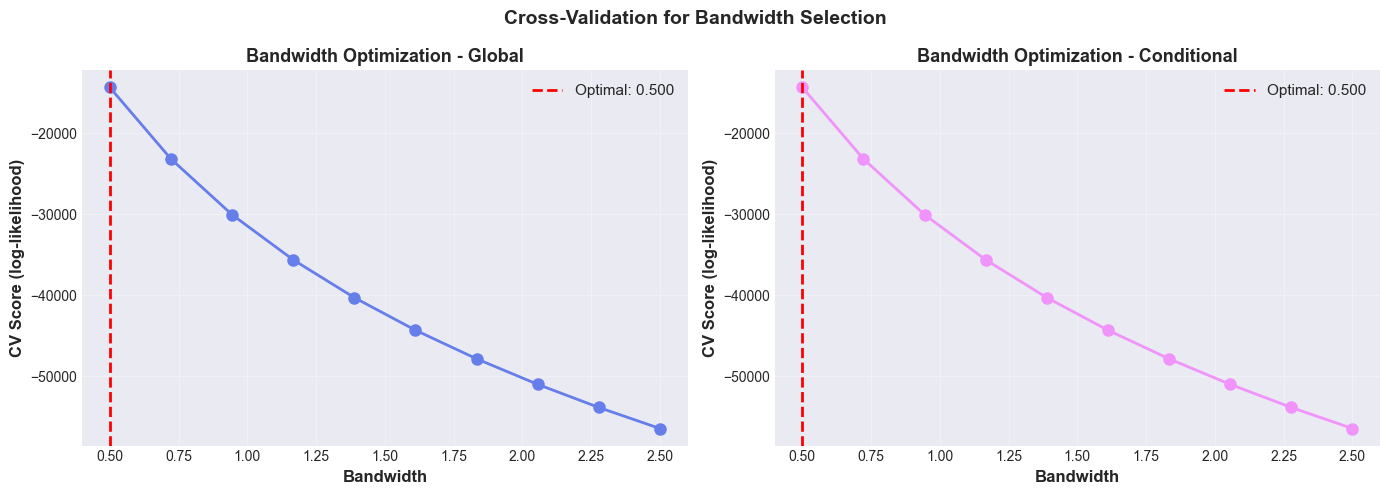

✓ Saved: results/comparison_visual.png


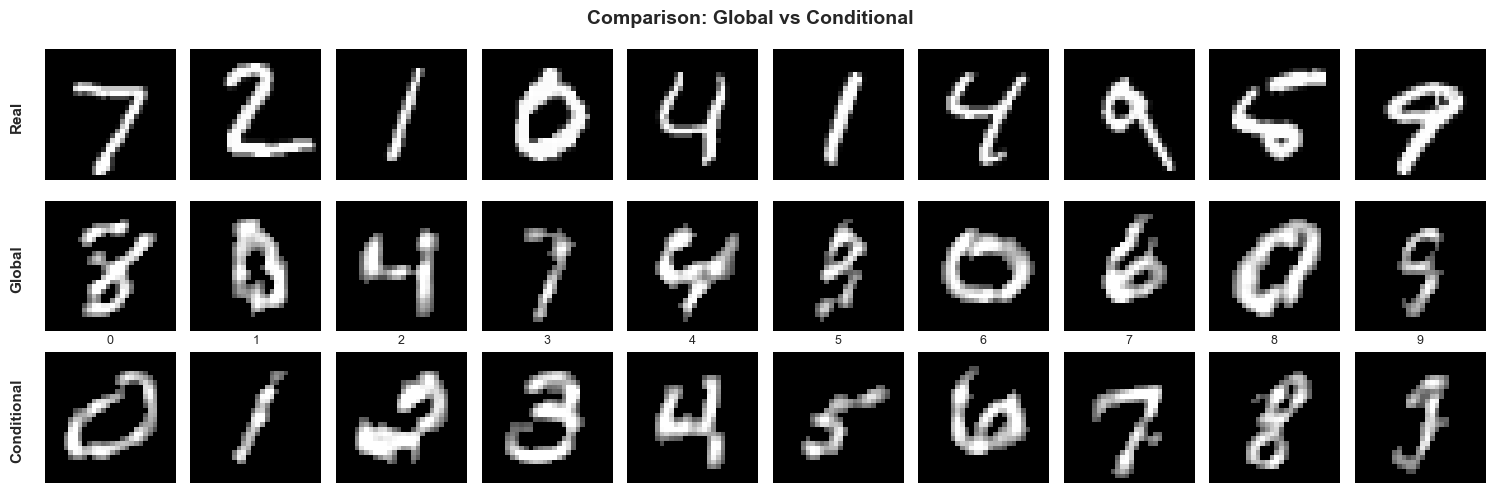


Generating 100 images (10 per digit)...
✓ Saved: results/conditional_grid.png


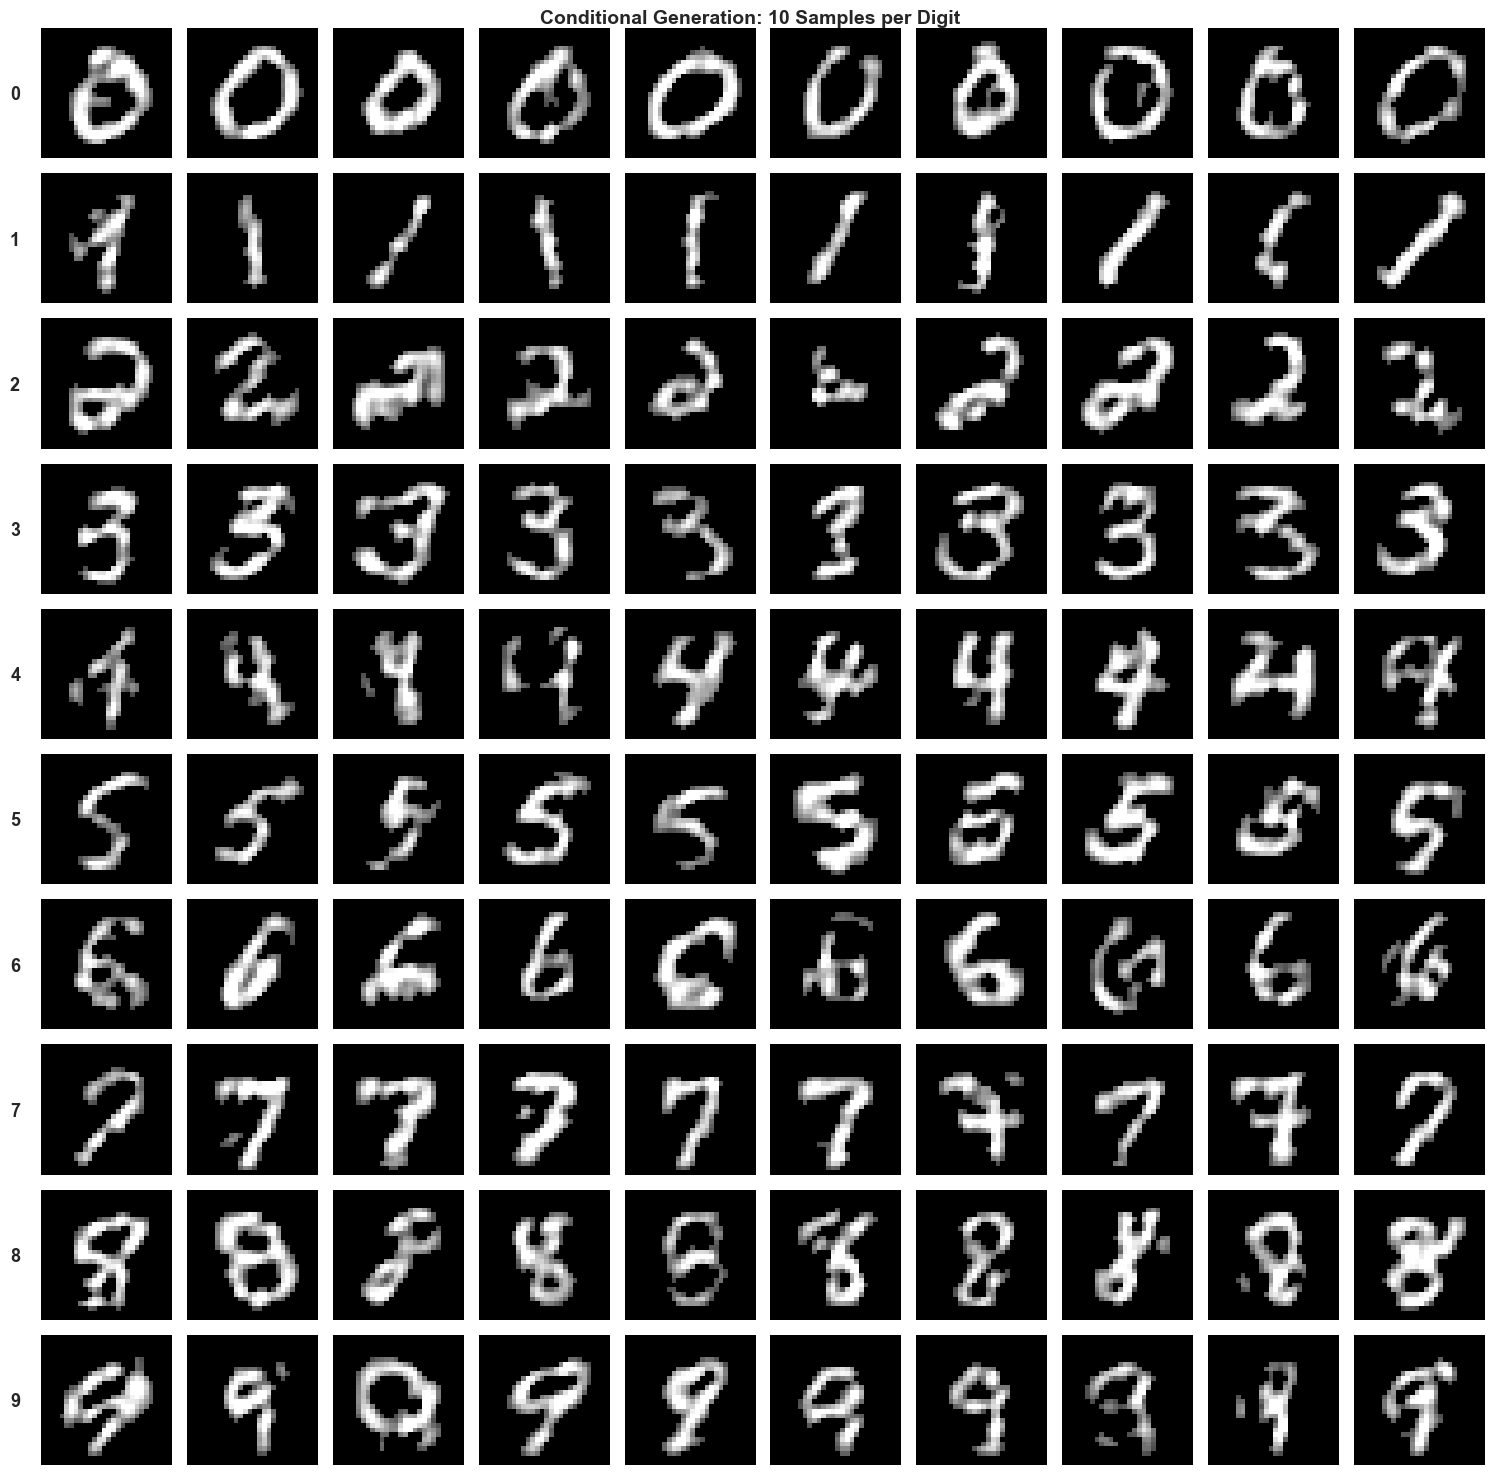

✓ Saved: results/comparison_metrics.png


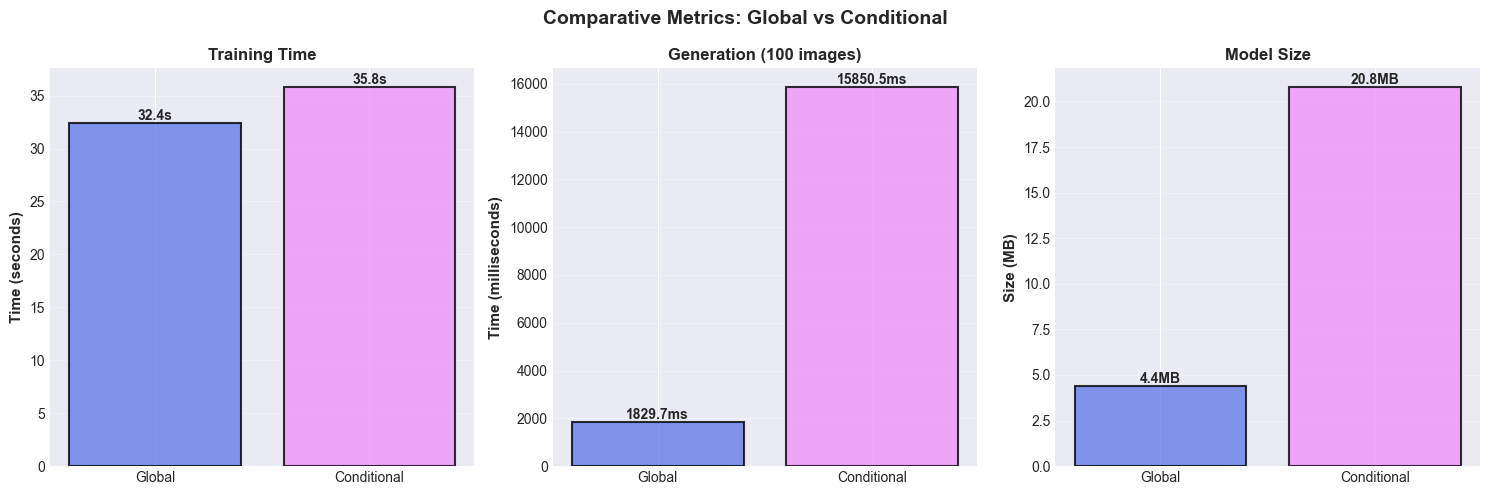

In [10]:
# =============================================================================
# 5. VISUAL COMPARISON
# =============================================================================
print("\n[5/5] Generating visualizations...")
print("-"*70)

os.makedirs('../results', exist_ok=True)

# Visualization 0: Bandwidth optimization (NEW)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Global
bw_global = grid.cv_results_['param_bandwidth'].data
scores_global = grid.cv_results_['mean_test_score']
axes[0].plot(bw_global, scores_global, 'o-', linewidth=2, markersize=8, color='#667eea')
axes[0].axvline(best_bandwidth, color='red', linestyle='--', linewidth=2,
               label=f'Optimal: {best_bandwidth:.3f}')
axes[0].set_xlabel('Bandwidth', fontsize=12, fontweight='bold')
axes[0].set_ylabel('CV Score (log-likelihood)', fontsize=12, fontweight='bold')
axes[0].set_title('Bandwidth Optimization - Global', fontsize=13, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].legend(fontsize=11)

# Conditionnel
bw_cond = grid.cv_results_['param_bandwidth'].data
scores_cond = grid.cv_results_['mean_test_score']
axes[1].plot(bw_cond, scores_cond, 'o-', linewidth=2, markersize=8, color='#f093fb')
axes[1].axvline(best_bandwidth_cond, color='red', linestyle='--', linewidth=2,
               label=f'Optimal: {best_bandwidth_cond:.3f}')
axes[1].set_xlabel('Bandwidth', fontsize=12, fontweight='bold')
axes[1].set_ylabel('CV Score (log-likelihood)', fontsize=12, fontweight='bold')
axes[1].set_title('Bandwidth Optimization - Conditional', fontsize=13, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].legend(fontsize=11)

plt.suptitle('Cross-Validation for Bandwidth Selection', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/bandwidth_optimization.png', dpi=150, bbox_inches='tight')
print("✓ Saved: results/bandwidth_optimization.png")
plt.show()

# =============================================================================
# Visualisation 1: Side-by-side comparison
# =============================================================================
fig, axes = plt.subplots(3, 10, figsize=(15, 5))

# Row 1: Real images
for i in range(10):
    img = np.squeeze(x_test[i]).reshape(28, 28)
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].axis('off')
axes[0, 0].text(-5, 14, 'Real', fontsize=11, fontweight='bold',
               rotation=90, va='center', ha='right')

# Row 2: Global
images_global = global_gen.generate(10, use_rejection=True, percentile=25)
for i in range(10):
    img = np.squeeze(images_global[i]).reshape(28, 28)
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].axis('off')
axes[1, 0].text(-5, 14, 'Global', fontsize=11, fontweight='bold',
               rotation=90, va='center', ha='right')

# Row 3: Conditional (mixed digits)
for i in range(10):
    digit = i % 10
    img = cond_gen.generate(digit, n_samples=1, use_rejection=True, percentile=25)
    img = np.squeeze(img).reshape(28, 28)
    axes[2, i].imshow(img, cmap='gray')
    axes[2, i].axis('off')
    axes[2, i].set_title(str(digit), fontsize=9)

axes[2, 0].text(-5, 14, 'Conditional', fontsize=11, fontweight='bold',
               rotation=90, va='center', ha='right')

plt.suptitle('Comparison: Global vs Conditional', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/comparison_visual.png', dpi=150, bbox_inches='tight')
print("✓ Saved: results/comparison_visual.png")
plt.show()

# =============================================================================
# Visualisation 2: Conditional generation (10x10 grid)
# =============================================================================
fig, axes = plt.subplots(10, 10, figsize=(15, 15))

print("\nGenerating 100 images (10 per digit)...")
for digit in range(10):
    images = cond_gen.generate(digit, n_samples=10, use_rejection=True)
    for i in range(10):
        img = np.squeeze(images[i]).reshape(28, 28)
        axes[digit, i].imshow(img, cmap='gray')
        axes[digit, i].axis('off')
        if i == 0:
            axes[digit, i].text(-5, 14, f'{digit}', fontsize=13,
                               fontweight='bold', va='center', ha='right')

plt.suptitle('Conditional Generation: 10 Samples per Digit',
             fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/conditional_grid.png', dpi=150, bbox_inches='tight')
print("✓ Saved: results/conditional_grid.png")
plt.show()

# =============================================================================
# Visualisation 3: Comparative metrics
# =============================================================================
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

methods = ['Global', 'Conditional']
colors = ['#667eea', '#f093fb']

# Training time
axes[0].bar(methods, [train_time_global, train_time_cond], color=colors,
           alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Time (seconds)', fontsize=11, fontweight='bold')
axes[0].set_title("Training Time", fontsize=12, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, time_val in enumerate([train_time_global, train_time_cond]):
    axes[0].text(i, time_val, f'{time_val:.1f}s',
                ha='center', va='bottom', fontweight='bold')

# Generation time
axes[1].bar(methods, [gen_time_global*1000, gen_time_cond*1000], color=colors,
           alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Time (milliseconds)', fontsize=11, fontweight='bold')
axes[1].set_title('Generation (100 images)', fontsize=12, fontweight='bold')
axes[1].grid(axis='y', alpha=0.3)
for i, time_val in enumerate([gen_time_global*1000, gen_time_cond*1000]):
    axes[1].text(i, time_val, f'{time_val:.1f}ms',
                ha='center', va='bottom', fontweight='bold')

# Model size
axes[2].bar(methods, [size_global, size_cond], color=colors,
           alpha=0.8, edgecolor='black', linewidth=1.5)
axes[2].set_ylabel('Size (MB)', fontsize=11, fontweight='bold')
axes[2].set_title('Model Size', fontsize=12, fontweight='bold')
axes[2].grid(axis='y', alpha=0.3)
for i, size_val in enumerate([size_global, size_cond]):
    axes[2].text(i, size_val, f'{size_val:.1f}MB',
                ha='center', va='bottom', fontweight='bold')

plt.suptitle('Comparative Metrics: Global vs Conditional',
            fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('../results/comparison_metrics.png', dpi=150, bbox_inches='tight')
print("✓ Saved: results/comparison_metrics.png")
plt.show()
